In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
import scipy as sp
import scipy.optimize as opt
import numba
import itertools

[ipython line magics](http://ipython.readthedocs.io/en/stable/interactive/magics.html#line-magics)

In [2]:
%precision 3
np.set_printoptions(precision=3)

# Validation
## Problems 1,2,3,4,5

In [3]:
_ = np.loadtxt('in.dta.txt')
x_dta_in, y_dta_in = _[:,:2], _[:,2]

_ = np.loadtxt('out.dta.txt')
x_dta_out, y_dta_out = _[:,:2], _[:,2]

def Phi(x):
    x1, x2 = x[0], x[1]
    return 1, x1, x2, x1**2, x2**2, x1*x2, np.abs(x1-x2), np.abs(x1+x2)

z_dta_in = np.apply_along_axis(Phi, 1, x_dta_in)
z_dta_out = np.apply_along_axis(Phi, 1, x_dta_out)

In [4]:
def solve_for(x_train, y_train, x_val, y_val):

    def solve_k(k, x_train, y_train, x_val, y_val):
        x_train_k = x_train[:, :k+1]
        x_val_k = x_val[:, :k+1]
        w = lin.pinv(x_train_k) @ y_train
        g_val = np.sign(x_val_k @ w)
        e = np.abs(np.sign(g_val - y_val))
        return np.mean(e)

    e2k = {}
    for k in range(3,8):
        e = solve_k(k, x_train, y_train, x_val, y_val)
        print('try: k:{} e:{:.2f}'.format(k, e))
        e2k[e] = k

    emin = min(e2k.keys())
    kmin = e2k[emin]
    print('best k:{} e:{:.2f}'.format(kmin, emin))
    return kmin, emin

In [5]:
# Task 1
k1,e1 = solve_for(z_dta_in[:25], y_dta_in[:25], z_dta_in[25:], y_dta_in[25:])

try: k:3 e:0.30
try: k:4 e:0.50
try: k:5 e:0.20
try: k:6 e:0.00
try: k:7 e:0.10
best k:6 e:0.00


In [6]:
# Task 2
k2,e2 = solve_for(z_dta_in[:25], y_dta_in[:25], z_dta_out, y_dta_out)

try: k:3 e:0.42
try: k:4 e:0.42
try: k:5 e:0.19
try: k:6 e:0.08
try: k:7 e:0.07
best k:7 e:0.07


In [7]:
# Task 3
k3,e3 = solve_for(z_dta_in[25:], y_dta_in[25:], z_dta_in[:25], y_dta_in[:25])

try: k:3 e:0.28
try: k:4 e:0.36
try: k:5 e:0.20
try: k:6 e:0.08
try: k:7 e:0.12
best k:6 e:0.08


In [8]:
# Task 4
k4,e4 = solve_for(z_dta_in[25:], y_dta_in[25:], z_dta_out, y_dta_out)

try: k:3 e:0.40
try: k:4 e:0.39
try: k:5 e:0.28
try: k:6 e:0.19
try: k:7 e:0.20
best k:6 e:0.19


In [9]:
# Task 5
print('Eout1(k1):{:.1f} Eout(k3):{:.1f}'.format(0.08, 0.19))

Eout1(k1):0.1 Eout(k3):0.2


# Validation Bias
## Problem #6

[CDF of the minimum of a set of ranom variables](https://stats.stackexchange.com/questions/220/how-is-the-minimum-of-a-set-of-random-variables-distributed)

If the CDF of $X_i$ is $F(x)$ and $Z=\min(X_i)$, then the CDF of $Z$ is given by $1−[1−F(x)]^n$.

[Expectation of the min of two independent random variables](https://math.stackexchange.com/questions/308230/expectation-of-the-min-of-two-independent-random-variables)

$\mathbb{E}(Z) = \int_0^1 z F_Z^\prime(z) \mathrm{d}z = \frac{1}{3} \left(1 + \frac{\alpha}{10} \right)$

In [10]:
sp.integrate.quad(lambda x: x * 1, 0, 1)[0]

0.500

In [11]:
sp.integrate.quad(lambda x: x * 2*(1-x), 0, 1)[0]

0.333

In [12]:
a = rnd.random(10**6)
b = rnd.random(10**6)
c = np.minimum(a,b)
a.mean(), b.mean(), c.mean()

(0.500, 0.500, 0.333)

In [13]:
# what's closer to 1/3rd?
0.4-1/3, 1/3-0.25

(0.067, 0.083)

# PLA vs SVM
### Problems 8,9,10

In [14]:
def random_points(n, vmin=-1.0, vmax=+1.0):
    return np.hstack([np.ones([n,1]), rnd.random([n,2])*(vmax-vmin)+vmin])

def random_line():
    p = random_points(2)
    a = (p[1,2] - p[0,1]) / (p[1,1] - p[0,1])
    b = p[0,2] - a * p[0,1]
    return np.array([-b, -a, 1.])

def line_y(w, x):
    return np.sign(x @ w)

def random_wxy(N=100):
    while True:
        w = random_line()
        x = random_points(N)
        y = line_y(w, x)
        if (y == 0).sum():
            continue
        if (y < 0).sum() > N/5 and (y > 0).sum() > N/5:
            return w, x, y

x_test = random_points(10**5)
        
def err_frac(y, y_test):
    return np.mean(np.abs(np.sign(y - y_test)))

In [15]:
@numba.njit
def pla(x, y):
    w = np.zeros(3)
    while True:
        e = np.where(x @ w * y <= 0)[0]
        if not e.size:
            return w
        i = rnd.choice(e)
        w += y[i] * x[i]

def do_pla(x, y, x_test, y_test):
    w = pla(x, y)
    y_pla = line_y(w, x_test)
    err = err_frac(y_pla, y_test)
    return err, w

`do_sklearn_svm()` uses scikit-learn's [SVC](http://scikit-learn.org/stable/modules/svm.html).

In [16]:
from sklearn import svm

def do_sklearn_svm(x, y, x_test, y_test):
    clf = svm.SVC(C=1e6, kernel='linear')
    clf.fit(x, y)
    y_svm = clf.predict(x_test)
    err = err_frac(y_svm, y_test)
    nsv = len(clf.support_vectors_)
    return err, nsv, clf

In [17]:
def pla_vs_svm(N, Nruns, do_svm):
    err_pla = np.empty(Nruns)
    err_svm = np.empty(Nruns)
    nsv_svm = np.empty(Nruns)
    fok_svm = np.empty(Nruns)
    for i in range(Nruns):
        w_goal, x_goal, y_goal = random_wxy(N=10)
        y_test = line_y(w_goal, x_test)
        e_pla, w_pla = do_pla(x_goal, y_goal, x_test, y_test)
        e_svm, nsv, clf = do_svm(x_goal, y_goal, x_test, y_test)
        err_pla[i] = e_pla
        err_svm[i] = e_svm
        fok_svm[i] = float(e_svm < e_pla)
        nsv_svm[i] = nsv
        if i % 100 == 0:
            print(i, end='..', flush=True)
    return nsv_svm.mean(), fok_svm.mean(), err_pla.mean(), err_svm.mean()

In [18]:
# Problem 8
pla_vs_svm(N=10, Nruns=1000, do_svm=do_sklearn_svm)

0..100..200..300..400..500..600..700..800..900..

(2.869, 0.622, 0.103, 0.085)

In [19]:
# Problem 9,10
pla_vs_svm(N=100, Nruns=1000, do_svm=do_sklearn_svm)

0..100..200..300..400..500..600..700..800..900..

(2.886, 0.654, 0.110, 0.090)

Primal SVM objective:
$$
  \min_w \frac12 \lVert w \rVert^2 \\
  \mbox{s.t.} \quad  y_i(w^Tx_i+b) \ge 1  \quad \forall i
$$
The corresponding dual problem:
$$
  \min_{\alpha} \frac12 \alpha^T K \alpha - 1^T \alpha \\
  \mbox{s.t.} \quad  \alpha_i \ge 0  \quad \forall i \\
  \mbox{and} \quad  y^T \alpha = 0
$$

# Cross Validation
### Problem #7

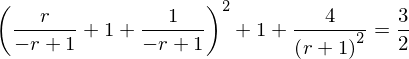

In [20]:
import sympy as sy
sy.init_printing()

def task7():
    # we've got three points
    r = sy.symbols('r', real=True)
    p0,p1,p2 = (-1,0), (r,1), (1,0)

    # approximate with constant: h0(x)=b
    def e0(p1,p2,p3):
        x1,y1 = p1
        x2,y2 = p2
        x3,y3 = p3
        # keep results symbolic, avoid conversion to IEEE floats
        ONEHALF = sy.Rational(1,2)
        # b is in the average of p1,p2
        b = ONEHALF*(y1+y2)
        # cross-validation error on p3
        e = (b-y3)**2
        return e

    # approximate with line: h1(x)=ax+b
    def e1(p1,p2,p3):
        x1,y1 = p1
        x2,y2 = p2
        x3,y3 = p3
        # find a,b
        a = (y2-y1)/(x2-x1)
        b = y1-a*x1
        # find h(x3)
        h3 = a*x3+b
        # cross validation error on p3
        e = (h3-y3)**2
        return e

    # total cross-validation error for h0
    cv0 = e0(p0,p1,p2)+e0(p1,p2,p0)+e0(p2,p0,p1)

    # total cross-validation error for h1
    cv1 = e1(p0,p1,p2)+e1(p1,p2,p0)+e1(p2,p0,p1)

    # solve equation for tie-point
    return sy.Eq(cv1, cv0)

task7()

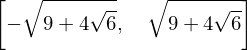

In [21]:
sy.solve(task7())